# Windowpane optimization for the precise QA configuration

In [34]:
from simsopt._core import load
from simsopt.geo import create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.geo import SurfaceRZFourier, create_equally_spaced_windowpane_grid, SurfaceScaled
from simsopt.geo import curves_to_vtk
from simsopt.field import apply_symmetries_to_curves, Coil, BiotSavart
from simsopt.field import apply_symmetries_to_currents, Current, ScaledCurrent, CurrentPenalty

import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from pathlib import Path
import numpy as np

from simsopt.mhd.vmec import Vmec

In [80]:
# Set constants
save_vtk = False
# vacuum vessel
HBT_R0 = 1
HBT_a = 0.5

# plasma surface
# surf_s = 1
# surf_dof_scale = 0.235
# surf_name = 'wout_NAS_n2_AR4.03.nc'

surf_s = 1
surf_dof_scale = 1
surf_name = 'wout_hbt_AR_3_finite_beta_000_000000.nc'

#surf_dof_scale = 1
#surf_name = 'wout_nfp2ginsburg_000_004484.nc'
#surf_name = 'wout_scaled_iota_015.nc'


In [81]:
# Create a surface representing the vacuum vessel
VV = SurfaceRZFourier()
VV.set_rc(0,0,HBT_R0)
VV.set_rc(1,0,HBT_a)
VV.set_zs(1,0,HBT_a)

In [82]:
nphi = 64  # nphi = ntheta >= 64 needed for accurate full-resolution runs
ntheta = 2*nphi
# Make higher resolution surface for plotting Bnormal
phi = np.linspace(0, 1, nphi, endpoint=True)
theta = np.linspace(0, 1, endpoint=True)

1
0.9213630731102943
0.3525308497138937
2.613567220735582
2.2602412621669035
1.3952759251410054
0.2639464108327385


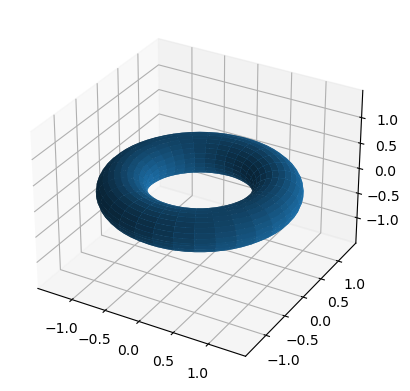

<Axes3D: >

In [83]:
# Initialize Scaled QA Surface with iota = 0.15
surf_dir = '/Users/jakehalpern/Projects/C-REX/Cleaned_up_for_Github/equilibria/'
surf_loc = surf_dir + surf_name
if surf_name.split(".nc")[1] == '':
    surf = SurfaceRZFourier.from_wout(surf_loc, surf_s, quadpoints_theta=theta, quadpoints_phi=phi)
elif surf_name.split(".")[1] == 'json':
    surf = load('precise_QA_scaled.json')
surf.set_dofs(surf_dof_scale*surf.get_dofs())
print(surf.nfp)
print(surf.major_radius())
print(surf.minor_radius())
print(surf.aspect_ratio())
print(surf.volume())
print(Vmec(surf_loc).iota_axis())
print(Vmec(surf_loc).iota_edge())
surf.plot(close=True)
#surf.set_rc(0,0,HBT_R0)

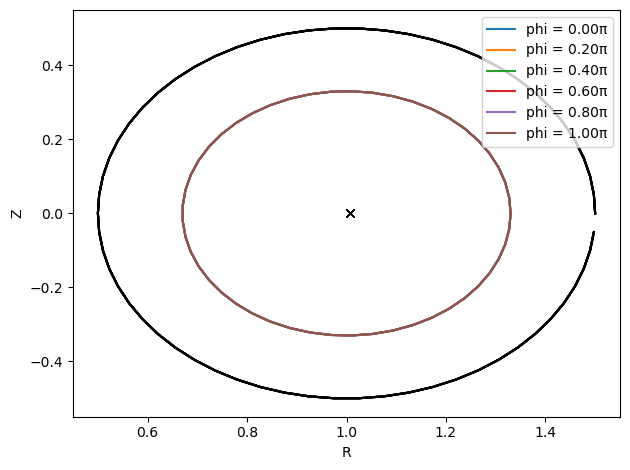

In [84]:
plt.figure()
#for phi in [0,0.25*2*np.pi/4,0.5*2*np.pi/4,0.75*2*np.pi/4, 2*np.pi/4, 1.25*2*np.pi/4, 1.5*2*np.pi/4, 1.75*2*np.pi/4]:
phi_array = np.arange(0, 1.01, 0.2)
#for phi in [0,0.25*2*np.pi/4,0.5*2*np.pi/4,0.75*2*np.pi/4, 2*np.pi/4, 1.25*2*np.pi/4, 1.5*2*np.pi/4, 1.75*2*np.pi/4]:
for phi in phi_array:
    cs = surf.cross_section(phi * np.pi)
    r = np.sqrt(cs[:,0]**2 + cs[:,1]**2)
    z = np.mean(cs, axis=0)[2]
    cs2 = VV.cross_section(phi)
    r2 = np.sqrt(cs2[:,0]**2 + cs2[:,1]**2)
    plt.plot(r, cs[:,2], label=f'phi = {phi:.2f}π')
    plt.plot(r2, cs2[:,2], 'k')
    plt.plot(np.mean(r), np.mean(z), 'kx')

plt.xlabel('R')
plt.ylabel('Z')
plt.legend(loc='upper right')
plt.tight_layout()


In [124]:
if save_vtk:
    surf.to_vtk(f'surf_name_s_{surf_s}_scale_{surf_dof_scale}')

In [125]:
from simsopt.geo import CurveSurfaceDistance, curves_to_vtk, create_equally_spaced_curves
from simsopt.field import Current, coils_via_symmetries

base_curves = create_equally_spaced_curves(10, surf.nfp, stellsym=True, R0=1, R1=.25, order=2, numquadpoints=61)
Jcsdist = CurveSurfaceDistance(base_curves, surf, 2e-2)
Jcsdist.shortest_distance()

0.026772305130050005

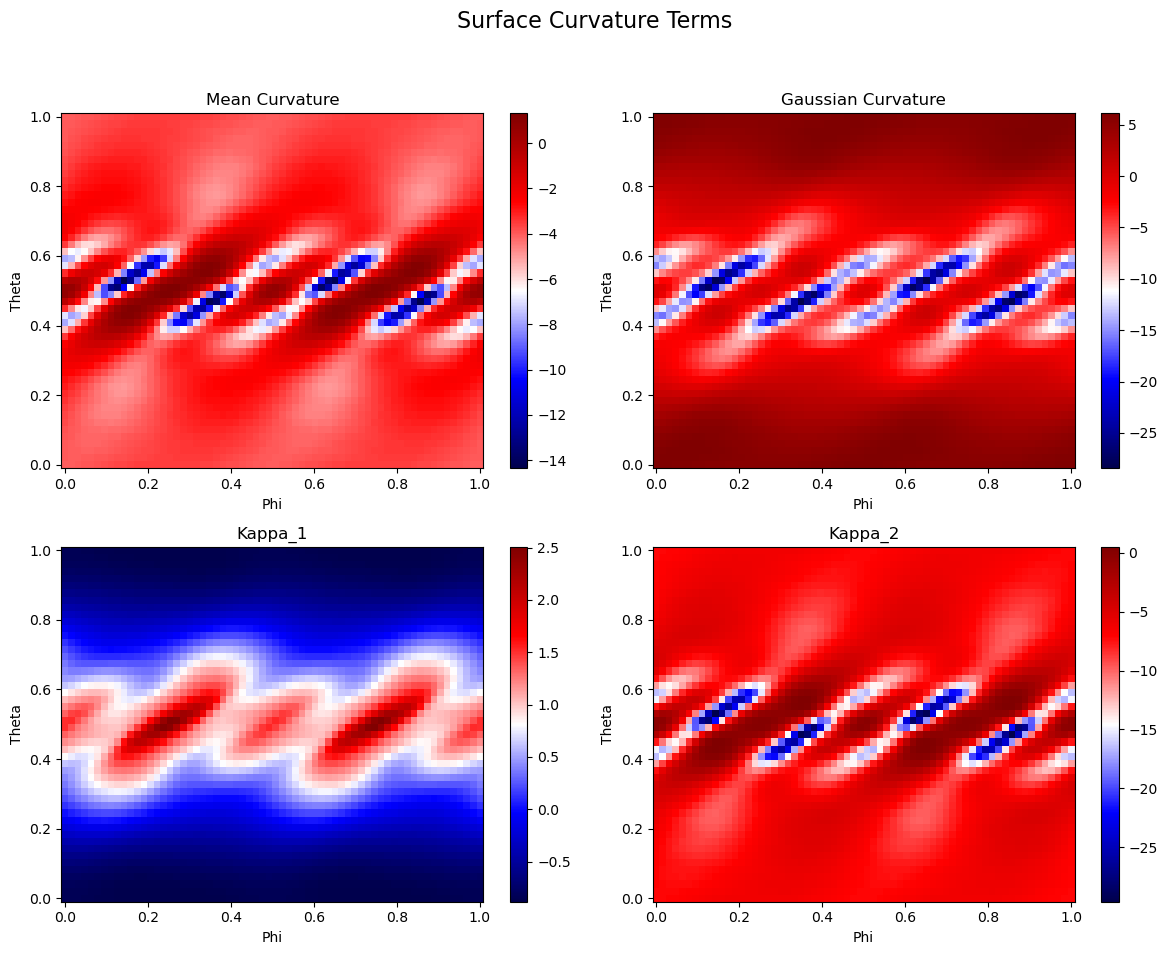

In [164]:
surface_curvatures = surf.surface_curvatures()
nphi,ntheta,_ = surf.gamma().shape
theta = surf.quadpoints_theta # note, these go from 0 to 1
phi = surf.quadpoints_phi
Phi, Theta = np.meshgrid(phi, theta)
# Extract each 64x64 array from the 64x64x4 array
mean_curvature = np.transpose(surface_curvatures[:, :, 0].reshape((nphi,ntheta)))
gaussian_curvature = np.transpose(surface_curvatures[:, :, 1].reshape((nphi,ntheta)))
kappa_1 = np.transpose(surface_curvatures[:, :, 2].reshape((nphi,ntheta)))
kappa_2 = np.transpose(surface_curvatures[:, :, 3].reshape((nphi,ntheta)))

# Create a figure and a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define titles for each subplot
titles = ['Mean Curvature', 'Gaussian Curvature', 'Kappa_1', 'Kappa_2']
data = [mean_curvature, gaussian_curvature, kappa_1, kappa_2]

# Plot each 64x64 array in the subplots
for ax, title, datum in zip(axes.flat, titles, data):
    #norm = TwoSlopeNorm(vmin=datum.min(), vcenter=0, vmax=datum.max())
    cax = ax.pcolormesh(Phi, Theta, datum, cmap='seismic', shading='auto')
    ax.set_title(title)
    ax.set_xlabel('Phi')
    ax.set_ylabel('Theta')
    fig.colorbar(cax, ax=ax)

# Set the main title for the entire plot
fig.suptitle('Surface Curvature Terms', fontsize=16)

# Adjust layout to make space for the main title
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

In [165]:
rad_circ = 100 / np.max([np.max(np.abs(kappa_1)), np.max(np.abs(kappa_2))])
print(f"minimum surface radius of curvature = {rad_circ:.2f} [cm]")

minimum surface radius of curvature = 3.37 [cm]
